Modified Fruit Image Classifier with TensorFlow Compatibility Fix

In [ ]:
import zipfile
import os
from google.colab import files  # Import the files module

# Upload the zip file
uploaded = files.upload()
zip_file_path = list(uploaded.keys())[0]  # Get the filename of the uploaded file
extract_path = '/content/converted_keras/'

# Extract the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Check the extracted files
extracted_files = os.listdir(extract_path)
print(extracted_files)

Saving converted_keras.zip to converted_keras.zip
['labels.txt', 'keras_model.h5']


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Model loaded successfully with custom objects!
Model loaded with 2 classes: ['Class 1', 'Class 2']

Upload images of birds or cars to test the classifier:


Saving apple.jpg to apple (5).jpg

===== Classification Results =====

Classifying image: apple (5).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


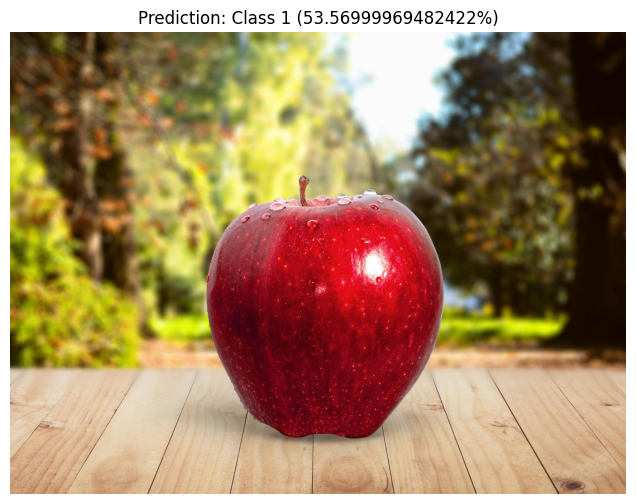

Image classified as: Class 1 with 53.56999969482422% confidence

Class probabilities:
Class 1: 53.56999969482422%
Class 2: 46.43000030517578%


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from google.colab import files
import os
import cv2

# First, let's patch TensorFlow to handle the 'groups' parameter
# This is necessary because Teachable Machine models may use this parameter
def load_model_with_custom_objects(model_path):
    # Define a custom DepthwiseConv2D layer that ignores the 'groups' parameter
    class CustomDepthwiseConv2D(tf.keras.layers.DepthwiseConv2D):
        def __init__(self, *args, **kwargs):
            # Remove the 'groups' argument if present
            if 'groups' in kwargs:
                del kwargs['groups']
            super(CustomDepthwiseConv2D, self).__init__(*args, **kwargs)

    # Load the model with the custom object
    custom_objects = {'DepthwiseConv2D': CustomDepthwiseConv2D}
    model = tf.keras.models.load_model(model_path, custom_objects=custom_objects)
    print("Model loaded successfully with custom objects!")
    return model

# Mount Google Drive (optional)
from google.colab import drive
drive.mount('/content/drive')

# Function to load class labels
def load_labels(labels_path):
    with open(labels_path, 'r') as f:
        labels = [line.strip() for line in f.readlines()]
        # Remove index numbers if they exist in the labels file
        labels = [name.split(' ', 1)[1] if ' ' in name and len(name.split(' ', 1)) > 1 else name for name in labels]
    return labels

# Function to preprocess and classify an image
def classify_image(model, img_path, class_labels):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalize pixel values

    # Make prediction
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])
    confidence = round(100 * np.max(predictions[0]), 2)

    # Display the image with prediction
    img_display = cv2.imread(img_path)
    img_display = cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(8, 6))
    plt.imshow(img_display)
    plt.title(f"Prediction: {class_labels[predicted_class]} ({confidence}%)")
    plt.axis('off')
    plt.show()

    # Print detailed results
    print(f"Image classified as: {class_labels[predicted_class]} with {confidence}% confidence")
    print("\nClass probabilities:")
    for i, class_name in enumerate(class_labels):
        print(f"{class_name}: {round(100 * predictions[0][i], 2)}%")

    return predicted_class, confidence

# Load the model directly from the extracted folder
extract_path = '/content/converted_keras/'
model_filename = os.path.join(extract_path, 'keras_model.h5')
labels_filename = os.path.join(extract_path, 'labels.txt')  # Define the path to labels.txt

# Step 3: Load the model and labels using the custom loader
model = load_model_with_custom_objects(model_filename)
class_labels = load_labels(labels_filename)

print(f"Model loaded with {len(class_labels)} classes: {class_labels}")

# Step 4: Upload test images for the new dataset (e.g., birds or cars)
print("\nUpload images of birds or cars to test the classifier:")
uploaded_images = files.upload()

# Step 5: Classify each uploaded image
print("\n===== Classification Results =====")
for img_name in uploaded_images.keys():
    print(f"\nClassifying image: {img_name}")
    classify_image(model, img_name, class_labels)


In [3]:
# Import necessary libraries
!pip install tensorflowjs

import os
import numpy as np
import json
import cv2
import tensorflow as tf
import tensorflowjs as tfjs
from google.colab import files
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode

In [ ]:
# Function to upload the model files
def upload_model_files():
    print("Please upload your model.json file")
    model_json = files.upload()
    model_json_name = list(model_json.keys())[0]

    print("Please upload your metadata.json file")
    metadata_json = files.upload()
    metadata_json_name = list(metadata_json.keys())[0]

    print("Please upload your weights.bin file")
    weights_bin = files.upload()
    weights_bin_name = list(weights_bin.keys())[0]

    # Create model directory if it doesn't exist
    if not os.path.exists('model'):
        os.makedirs('model')

    # Move files to the model directory with expected names
    os.rename(model_json_name, 'model/model.json')
    os.rename(metadata_json_name, 'model/metadata.json')
    os.rename(weights_bin_name, 'model/weights.bin')

    return 'model'

# Function to load the model using tensorflowjs
def load_model(model_dir):
    # Load the model using tensorflowjs
    model = tfjs.converters.load_keras_model(
        os.path.join(model_dir, 'model.json')
    )

    # Load metadata
    with open(os.path.join(model_dir, 'metadata.json'), 'r') as f:
        metadata = json.load(f)

    return model, metadata

# Function to take a webcam photo
def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});
      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

# Function to preprocess the image for MNIST model
def preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (28, 28))
    image = image.astype('float32') / 255.0
    image = image.flatten().reshape(1, -1)  # flatten the image
    print("Input shape after flattening:", image.shape)
    return image

# Function to prepare input for the model
def prepare_input(image):
    # No additional keypoints are necessary for MNIST
    return np.array(image).reshape(1, 28, 28, 1)

# Main function
def run_digit_recognition():
    model_dir = upload_model_files()
    model, metadata = load_model(model_dir)

    print(f"Model loaded. Classes: {metadata.get('labels', [])}")

    use_webcam = input("Use webcam for digit recognition? (yes/no): ").strip().lower()

    if use_webcam == 'yes':
        image_path = take_photo()
    else:
        print("Please upload an image:")
        uploaded = files.upload()

        # ✅ Check if the file was uploaded before proceeding
        if not uploaded:
            print("No file uploaded. Please try again.")
            return

        image_path = list(uploaded.keys())[0]

    model_input = preprocess_image(image_path)

    predictions = model.predict(model_input)[0]
    print("\nPrediction Results:")
    for i, label in enumerate(metadata.get('labels', [])):
        print(f"{label}: {predictions[i] * 100:.2f}%")

    max_index = np.argmax(predictions)
    print(f"\nDetected digit: {metadata['labels'][max_index]} with {predictions[max_index] * 100:.2f}% confidence")

# Run the script
if __name__ == "__main__":
    run_digit_recognition()


In [12]:
import os
import numpy as np
import tensorflow as tf
import librosa
import soundfile as sf
from google.colab import files

In [13]:
def upload_model_files():
    print("Please upload your sound classifier tflite model")
    uploaded = files.upload()
    model_file = list(uploaded.keys())[0]

    print("Please upload your labels.txt file")
    uploaded = files.upload()
    labels_file = list(uploaded.keys())[0]

    # Create model directory if it doesn't exist
    if not os.path.exists('model'):
        os.makedirs('model')

    # Move files to the model directory with expected names
    os.rename(model_file, 'model/soundclassifier_with_metadata.tflite')
    os.rename(labels_file, 'model/labels.txt')

    return 'model'

In [14]:
def load_model(model_dir):
    # Load TFLite model and allocate tensors
    interpreter = tf.lite.Interpreter(model_path=os.path.join(model_dir, 'soundclassifier_with_metadata.tflite'))
    interpreter.allocate_tensors()

    # Load labels
    with open(os.path.join(model_dir, 'labels.txt'), 'r') as f:
        labels = [line.strip() for line in f.readlines()]

    return interpreter, labels

In [15]:
def record_audio(file_name="audio.wav", duration=5, sample_rate=16000):
    import sounddevice as sd

    print(f"Recording audio for {duration} seconds...")
    recording = sd.rec(int(duration * sample_rate), samplerate=sample_rate, channels=1, dtype='float32')
    sd.wait()

    # Save to a file
    sf.write(file_name, recording, sample_rate)
    print(f"Audio recorded and saved to {file_name}")

    return file_name

def upload_audio():
    print("Please upload an audio file (.wav)")
    uploaded = files.upload()
    file_name = list(uploaded.keys())[0]
    print(f"Uploaded {file_name}")
    return file_name

In [16]:
def preprocess_audio(file_name, input_shape):
    data, sample_rate = librosa.load(file_name, sr=16000)

    # Convert to float32
    data = np.array(data, dtype=np.float32)

    # Pad or truncate to match the input shape
    expected_length = input_shape[1]
    if len(data) < expected_length:
        data = np.pad(data, (0, expected_length - len(data)))
    else:
        data = data[:expected_length]

    # Reshape to input shape
    data = np.expand_dims(data, axis=0)  # Add batch dimension

    print(f"Prepared input shape: {data.shape}")
    return data

In [17]:
def run_inference(interpreter, input_data, labels):
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Set input tensor
    interpreter.set_tensor(input_details[0]['index'], input_data)

    # Run inference
    interpreter.invoke()

    # Get output tensor
    output = interpreter.get_tensor(output_details[0]['index'])[0]

    # Display results
    print("\nPrediction Results:")
    for i, score in enumerate(output):
        print(f"{labels[i]}: {score * 100:.2f}%")

    # Get the highest confidence prediction
    max_index = np.argmax(output)
    print(f"\nPredicted sound: {labels[max_index]} with {output[max_index] * 100:.2f}% confidence")

In [ ]:
def main():
    model_dir = upload_model_files()
    interpreter, labels = load_model(model_dir)

    print(f"\nModel Loaded! Detected Classes: {labels}\n")

    choice = input("Record audio or upload file? (record/upload): ").strip().lower()

    if choice == 'record':
        file_name = record_audio()
    else:
        file_name = upload_audio()

    # Get input shape from the model
    input_shape = interpreter.get_input_details()[0]['shape']

    input_data = preprocess_audio(file_name, input_shape)
    run_inference(interpreter, input_data, labels)

# Run
if __name__ == "__main__":
    main()

Please upload your sound classifier tflite model
